# ModelV2
Improves of V1 by taking G-Buffers as input and G-buffer feature extractor.

In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\minorProject\WDSS\jupyter_notebooks
d:\minorProject\WDSS


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from config import Settings, device
from network.modules.feature_extractors import HRGBufferFeatureExtractor, LRFrameFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from utils.image_utils import ImageUtils
from network.dataset import WDSSDatasetCompressed, GB_Type
from utils.wavelet import WaveletProcessor

from typing import List, Tuple, Union

# Model

In [3]:
class WDSSV3(nn.Module):
    def __init__(self):
        super(WDSSV3, self).__init__()

        self.upscale_factor = 2
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(48, 32, [64, 64, 64, 64])
        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 32, [32, 32])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffers: torch.Tensor) -> torch.Tensor:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffers, 2)

        lr_frame_features = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        
        lr_frame_wavelet = WaveletProcessor.batch_wt(lr_frame)
        
        lr_frame_wavelet_upsampled = F.interpolate(lr_frame_wavelet, scale_factor=self.upscale_factor, mode='nearest')
        
        # Upsample the low resolution frame features
        lr_frame_features_upsampled = F.interpolate(lr_frame_features, scale_factor=self.upscale_factor, mode='nearest')
        
        hr_gbuffers_features = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)
        
        # Concatenate the features
        features = torch.cat((lr_frame_features_upsampled, hr_gbuffers_features), dim=1)
        
        # Fuse the features
        fused_features = self.feature_fusion(features)
        
        # Elementwise sum the fused features and the upsampled wavelet
        final_wavelet = fused_features + lr_frame_wavelet_upsampled
        
        
        # Inverse wavelet transform the final wavelet
        inverse_wavelet_output = WaveletProcessor.batch_iwt(final_wavelet)

        return inverse_wavelet_output


# Dataset

In [4]:
dataset_folder = Settings.dataset_path

dataset = WDSSDatasetCompressed(dataset_folder, 120)
test = dataset[0]
print(test['LR'].shape)
print(test['HR'].shape)
print(len(dataset))

torch.Size([3, 360, 640])
torch.Size([3, 720, 1280])
120


In [5]:
# Model
model = WDSSV3().to(device)

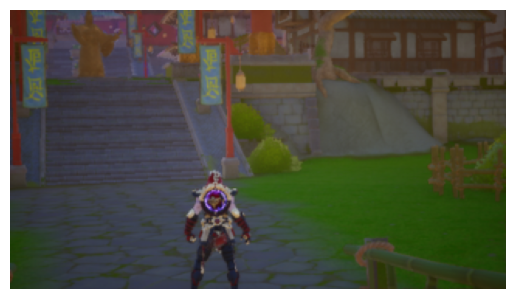

In [6]:
model.eval()
with torch.no_grad():
    res = model(dataset[0]['LR'].unsqueeze(0).to(device), dataset[0]['GB'].unsqueeze(0).to(device))
    ImageUtils.display_image(res.cpu())

In [7]:
# Training Loop
import threading

# Criterion is combination of MSE and SSIM
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()

    def forward(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        mse_loss = F.mse_loss(output, target)
        # Calculate SSIM
        ssim_loss = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(output, target, dim=1) + 1) / 2, 0, 1))
        return mse_loss + ssim_loss

criterion = Criterion()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# Dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 10
epoch_loss: float = 0

In [8]:
# # Training Loop
# import threading

# # Criterion
# criterion = nn.MSELoss()
# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # Dataloader
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 10
epoch_loss: float = 0

def do_nothing():
    ...

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_frames = batch['HR'].to(device)

    optimizer.zero_grad()

    output = model(lr_frames, hr_gbuffers)
    loss = criterion(output, hr_frames)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i}, Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(dataloader):
        # print("Data loading completed")

        # Wait for the previous batch to finish
        if threadu.is_alive():
            threadu.join()

        # print(f"Batch {i} started")

        # Start the training process
        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if threadu.is_alive():
        threadu.join()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

# Save the model
torch.save(model.state_dict(), "model/WDSSV3.pth")
    


Batch 0, Loss: 0.001530904439277947
Batch 1, Loss: 0.0009163817740045488
Batch 2, Loss: 0.0005693985731340945
Batch 3, Loss: 0.0004946229164488614
Batch 4, Loss: 0.00046076771104708314
Batch 5, Loss: 0.0004675862437579781
Batch 6, Loss: 0.00045640295138582587
Batch 7, Loss: 0.00038137478986755013
Batch 8, Loss: 0.0004664358275476843
Batch 9, Loss: 0.00038664977182634175
Batch 10, Loss: 0.0004678151453845203
Batch 11, Loss: 0.000507859222125262
Batch 12, Loss: 0.0004897206672467291
Batch 13, Loss: 0.0003996945160906762
Batch 14, Loss: 0.0004641124396584928
Epoch: 0, Loss: 0.008459726988803595
Batch 0, Loss: 0.00037253767368383706
Batch 1, Loss: 0.0004711108631454408
Batch 2, Loss: 0.0004924058448523283
Batch 3, Loss: 0.0004308659117668867
Batch 4, Loss: 0.0004051456635352224
Batch 5, Loss: 0.0004657429235521704
Batch 6, Loss: 0.0004556722124107182
Batch 7, Loss: 0.0004421172197908163
Batch 8, Loss: 0.0004781876632478088
Batch 9, Loss: 0.00042116528493352234
Batch 10, Loss: 0.00040948722

In [9]:
# Save the model
torch.save(model.state_dict(), "model/WDSSV3.pth")

In [10]:
# Load the model
model.load_state_dict(torch.load("model/WDSSV3.pth"))

C:\Users\kunwa\AppData\Local\Temp\ipykernel_11308\32629787.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/WDSSV3.pth"))


<All keys matched successfully>

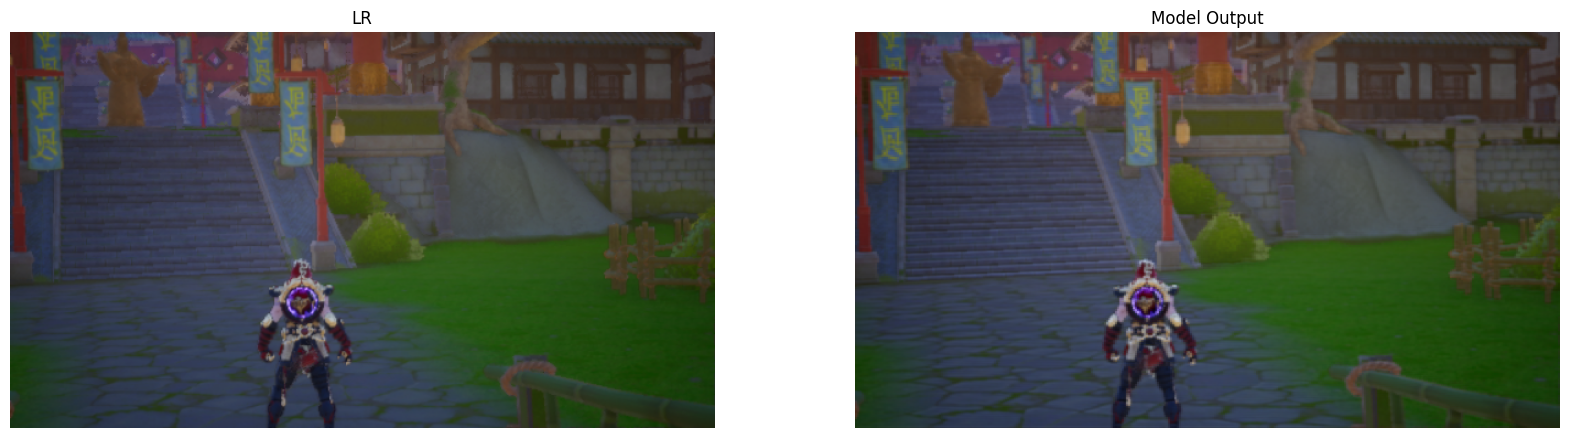

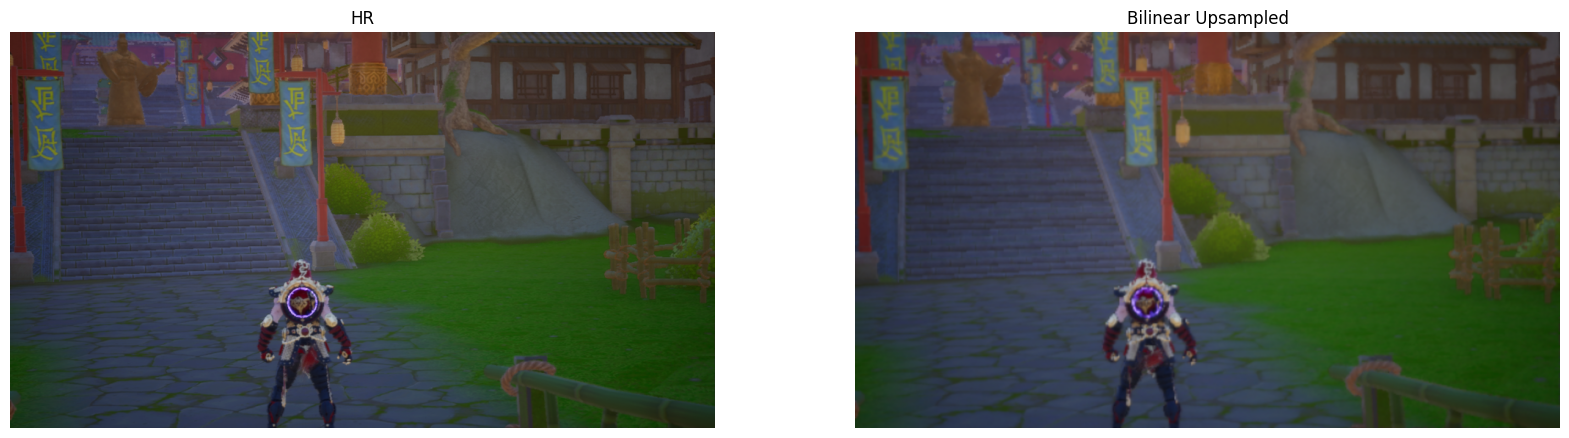

Model Error: 0.0006056422716937959, Bilinear Error: 0.0004791444807779044
Model SSIM: 0.0, Bilinear SSIM: 0.0


In [11]:
# Compare the models output with bilinear upsampled output
frame_no = 0

model.eval()
with torch.no_grad():
    res = model(dataset[frame_no]['LR'].unsqueeze(0).to(device), dataset[frame_no]['GB'].unsqueeze(0).to(device))
    binilear_upsampled = F.interpolate(dataset[frame_no]['LR'].unsqueeze(0), scale_factor=2, mode='bilinear')
    ImageUtils.display_images([dataset[frame_no]['LR'].unsqueeze(0) ,res.cpu()],
                              ["LR", "Model Output"])
    ImageUtils.display_images([dataset[frame_no]['HR'].unsqueeze(0), binilear_upsampled],
                              ["HR", "Bilinear Upsampled"])

# Compare the error between the models output and bilinear upsampled output
model_error = F.mse_loss(res.cpu(), dataset[frame_no]['HR'].unsqueeze(0))
bilinear_error = F.mse_loss(binilear_upsampled, dataset[frame_no]['HR'].unsqueeze(0))

model_ssim = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(res.cpu(), dataset[frame_no]['HR'].unsqueeze(0), dim=1) + 1) / 2, 0, 1))
bilinear_ssim = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(binilear_upsampled, dataset[frame_no]['HR'].unsqueeze(0), dim=1) + 1) / 2, 0, 1))

print(f"Model Error: {model_error}, Bilinear Error: {bilinear_error}")
print(f"Model SSIM: {model_ssim}, Bilinear SSIM: {bilinear_ssim}")



In [12]:
from network.loss import ImageComparator

In [13]:
import torch
from skimage.metrics import structural_similarity as ssim

# Ensure both tensors are in the same shape and type
hr_image = dataset[frame_no]['HR'].unsqueeze(0)  # Ensure batch dimension added if required
model_image = res.cpu()

# Remove batch dimension
model_image = model_image.squeeze(0)  # Shape becomes (3, 720, 1280)
hr_image = hr_image.squeeze(0)        # Shape becomes (3, 720, 1280)

# Convert to numpy
ssim = ImageComparator.ssim(hr_image, model_image)
psnr = ImageComparator.psnr(hr_image, model_image)

print(f"SSIM: {ssim}, PSNR: {psnr}")

ImageComparator.compare_images(hr_image, model_image)


SSIM: 0.8625558018684387, PSNR: 32.17784118652344
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_locatio

Comparison results for unnamed images:
PSNR: 32.18
SSIM: 0.8626
LPIPS: 0.1080


{'psnr': 32.17784118652344,
 'ssim': np.float32(0.8625558),
 'lpips': 0.10801287740468979,
 'img1_features': [tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.2719, 0.1050,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.2689, 0.0848,  ..., 0.0000, 0.0000, 0.1953],
            ...,
            [0.0000, 0.3643, 0.0702,  ..., 0.0262, 0.0000, 0.5471],
            [0.0000, 0.3902, 0.1186,  ..., 0.0784, 0.0000, 0.5989],
            [0.0000, 0.5597, 0.3736,  ..., 0.3564, 0.1187, 0.7549]],
  
           [[0.0247, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.1433, 0.0000, 0.0000,  ..., 0.0000, 0.0334, 0.0000],
            [0.0412, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.2216, 0.0000, 0.0000,  ..., 0.0000, 0.1018, 0.0000],
            [0.3700, 0.1048, 0.0000,  ..., 0.0000, 0.3144, 0.0000],
            [0.2095, 0.0329, 0.0000,  ..., 0.0000, 0.1926, 0.0000]],
  
           [[0.0000, 0.0000, 0.000